# Supervised analysis

## Table of Contents
- [Manually select features](#select)
- [Apply supervised learning techniques: Lasso, Ridge, Random Forest, Gradient Boosting](#model)
    - [Hypothesis Testing](#hypothesis)
    - [Ablation analysis](#ablation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyarrow.feather import read_feather, write_feather
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations
from sklearn.inspection import permutation_importance
from scipy.stats import f_oneway
from collections import defaultdict

In [2]:
pd.set_option('display.max_columns', None)
file_path = 'df_train.feather'
df_all_features = read_feather(file_path)
df_all_features

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,-0.320320,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.339016,-0.072211,-0.281306,-0.237312,-0.241584
1,large,2000-03-31,2000,1,-0.313688,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.330704,-0.083578,-0.265944,-0.248671,-0.276122
2,small,2000-03-31,2000,1,-0.246587,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.258426,0.048942,-0.210391,-0.096449,-0.185889
3,intermediate,2000-06-30,2000,2,-0.318363,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041245,-0.182477,-0.103936,-0.046680,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.336200,-0.063701,-0.281284,-0.232154,-0.250873
4,large,2000-06-30,2000,2,-0.312529,-0.161561,-0.177713,-0.135487,0.647394,0.409316,-0.119436,-0.018563,-0.220787,-0.278933,0.218864,0.142254,0.102682,-0.237248,-0.151762,-0.041245,-0.182477,-0.103936,-0.046680,0.228748,0.050737,0.154819,-0.293972,-0.163249,-0.204478,NaN,NaN,0.088630,-0.328362,-0.072784,-0.266718,-0.257770,-0.250324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,large,2023-09-30,2023,3,0.469401,0.207049,0.259088,-0.155757,0.509780,0.095502,0.264359,NaN,0.287912,0.369981,-0.163571,0.065263,0.021328,0.426574,0.018970,0.059834,0.198734,0.192374,-0.043555,-0.107859,-0.096418,-0.072655,0.391716,0.249882,0.312422,NaN,0.172701,0.020799,0.485986,0.513511,0.314794,0.576191,0.647473
284,small,2023-09-30,2023,3,0.633644,0.207049,0.259088,-0.155757,0.509780,0.095502,0.264359,NaN,0.287912,0.369981,-0.163571,0.065263,0.021328,0.426574,0.018970,0.059834,0.198734,0.192374,-0.043555,-0.107859,-0.096418,-0.072655,0.391716,0.249882,0.312422,NaN,0.172701,0.020799,0.607268,0.777287,0.509985,0.470050,0.457886
285,intermediate,2023-12-31,2023,4,0.094108,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053679,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.391813,0.257734,0.321299,NaN,0.177315,-0.002959,0.064007,0.459389,0.043556,0.538106,-0.088592
286,large,2023-12-31,2023,4,0.482736,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053679,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.3918

<a id="select"></a>
# Manually select features

In [3]:
selected_features = ['cpi','fed_fund_rate','housing_starts','personal_savings_rate','umich_consumer_sentiment_index']
correlation_matrix = df_all_features[selected_features].corr()
correlation_matrix

,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
cpi,1.000000,-0.265044,-0.250698,0.287899,-0.404934
fed_fund_rate,-0.265044,1.000000,0.459629,-0.388953,0.306560
housing_starts,-0.250698,0.459629,1.000000,-0.182604,0.471492
personal_savings_rate,0.287899,-0.388953,-0.182604,1.000000,-0.087977
umich_consumer_sentiment_index,-0.404934,0.306560,0.471492,-0.087977,1.000000


Text(0.5, 1.0, 'Correlation between hand-picked metrics')

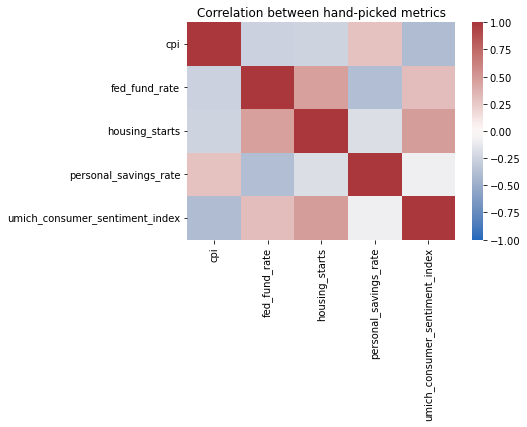

In [4]:
sns.heatmap(correlation_matrix, vmin = -1, vmax = 1, cmap="vlag").set_title(
    "Correlation between hand-picked metrics"
)

In [5]:
# Create new dataframe with only the selected features 
df = df_all_features.loc[:, ['category'
                                , 'date'
                                , 'year'
                                , 'quarter'
                                , 'total_deposits'
                                , 'cpi'
                                , 'fed_fund_rate'
                                , 'housing_starts'
                                , 'personal_savings_rate'
                                , 'umich_consumer_sentiment_index']]

In [6]:
# Shift total deposits to a quarter back so that other features are "predicting" it
lagged_df = df.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))

lagged_df = lagged_df.dropna().reset_index(drop=True)
lagged_df

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index,total_deposits_lag1
0,intermediate,2000-06-30,2000,2,-0.318363,-0.177713,0.647394,0.142254,-0.046680,0.228748,-0.320320
1,intermediate,2000-09-30,2000,3,-0.317856,-0.172838,0.726905,0.070543,-0.034180,0.220712,-0.318363
2,intermediate,2000-12-31,2000,4,-0.316432,-0.168938,0.722318,0.108378,-0.046680,0.198391,-0.317856
3,intermediate,2001-03-31,2001,1,-0.310238,-0.165362,0.641278,0.130816,-0.040430,0.099284,-0.316432
4,intermediate,2001-06-30,2001,2,-0.309690,-0.159512,0.460850,0.152373,-0.031055,0.043034,-0.310238
...,...,...,...,...,...,...,...,...,...,...,...
280,small,2022-12-31,2022,4,0.604950,0.234129,0.197853,0.056904,-0.087305,-0.211430,0.602027
281,small,2023-03-31,2023,1,0.617503,0.237893,0.388984,0.016429,-0.043555,-0.166788,0.604950
282,small,2023-06-30,2023,2,0.623954,0.251521,0.465437,0.019949,-0.018555,-0.177502,0.617503
283,small,2023-09-30,2023,3,0.633644,0.259088,0.509780,0.065263,-0.043555,-0.107859,0.623954


<a id="model"></a>
# Apply supervised learning techniques: Lasso, Ridge, Random Forest, Gradient Boosting

In [7]:
random_state = 42

In [8]:
def run_sklearn_model(lagged_df, selected_features, model, param_grid, cv=3):
    """
    Run a sklearn model for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): where 'total_deposits' is response variable
    - selected_features (list): list of most independent features in the model
    - model: a sklearn model, e.g. Lasso
    - param_grid (dict): param_grid to pass into GridSearchCV

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """

    categories = lagged_df['category'].unique()
    best_models = {}

    for category in categories:
        X = lagged_df[lagged_df['category'] == category][selected_features]
        y = lagged_df[lagged_df['category'] == category]['total_deposits']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring="neg_mean_squared_error")
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        best_models[category] = {'model': best_model, 'rmse': rmse, 'r2': r2}

    return best_models

In [9]:
grid_lasso = {'alpha': np.logspace(-4, 2, 10)}
best_models_lasso = run_sklearn_model(lagged_df, selected_features, Lasso(max_iter=10000),
                                      grid_lasso, cv=5)
best_models_lasso

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'rmse': 0.01941133748474301,
  'r2': 0.9704883069119017},
 'large': {'model': Lasso(alpha=0.0001, max_iter=10000),
  'rmse': 0.03293553475094769,
  'r2': 0.9827820749365993},
 'small': {'model': Lasso(alpha=0.00046415888336127773, max_iter=10000),
  'rmse': 0.0433201323465596,
  'r2': 0.9598402815693345}}

In [10]:
grid_ridge = {'alpha': [0.01, 0.1, 1, 10]}
best_models_ridge = run_sklearn_model(lagged_df, selected_features, Ridge(), grid_ridge)
best_models_ridge

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'model': Ridge(alpha=0.01),
  'rmse': 0.016430116447901332,
  'r2': 0.9788571032893162},
 'large': {'model': Ridge(alpha=0.01),
  'rmse': 0.03291869222912242,
  'r2': 0.9827996801847124},
 'small': {'model': Ridge(alpha=0.01),
  'rmse': 0.043833939745084066,
  'r2': 0.9588819867359585}}

In [11]:
grid_forest = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
best_models_random_forest = run_sklearn_model(lagged_df, selected_features,
                                              RandomForestRegressor(random_state=random_state),
                                              grid_forest)
best_models_random_forest

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.007584791766066514,
  'r2': 0.9954942143311664},
 'large': {'model': RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  'rmse': 0.009462798555142867,
  'r2': 0.9985786842625077},
 'small': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.023690115814869073,
  'r2': 0.9879899316930624}}

In [12]:
grid_boost = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
best_models_gradient_boosting = run_sklearn_model(lagged_df, selected_features,
                                                  GradientBoostingRegressor(random_state=random_state),
                                                  param_grid = grid_boost)
best_models_gradient_boosting

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'model': GradientBoostingRegressor(n_estimators=50, random_state=42),
  'rmse': 0.013193357919761627,
  'r2': 0.9863669227963684},
 'large': {'model': GradientBoostingRegressor(n_estimators=150, random_state=42),
  'rmse': 0.012669429421176815,
  'r2': 0.9974521990924148},
 'small': {'model': GradientBoostingRegressor(learning_rate=0.05, n_estimators=150, random_state=42),
  'rmse': 0.02810258062057894,
  'r2': 0.9830993458540705}}

In [13]:
categories = lagged_df['category'].unique()

def plot_error_chart(error_values, title, xlab, ylab):
    """
    Plots an error chart with given title, and labels.

    Args:
    - error_values (Dict): where each key is the name of a model type, and each value is a list of its errors per category
    - title (str): chart title
    - xlab (str): chart x-label
    - ylab (str): chart y-label

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.2
    index = range(len(categories))
    
    for i, (method, error) in enumerate(error_values.items()):
        ax.bar([x + i * bar_width for x in index], error, bar_width, label=method)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.set_xticks([x + bar_width for x in index])
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

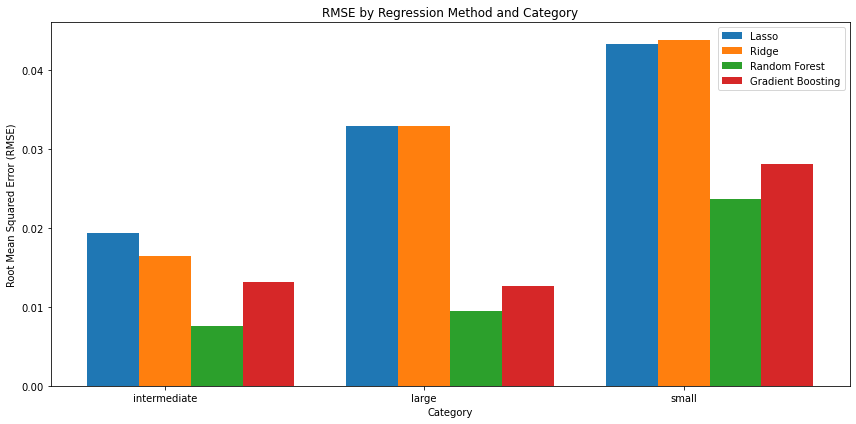

In [14]:
# Results from the four regression methods for "mse"
rmse_values = {
    'Lasso': [best_models_lasso[cat]['rmse'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['rmse'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['rmse'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['rmse'] for cat in categories]
}

plot_error_chart(rmse_values, "RMSE by Regression Method and Category", "Category", "Root Mean Squared Error (RMSE)")

#### Conclusion
"Random Forest" is best performing model for every category, but other models also perform reasonably well.

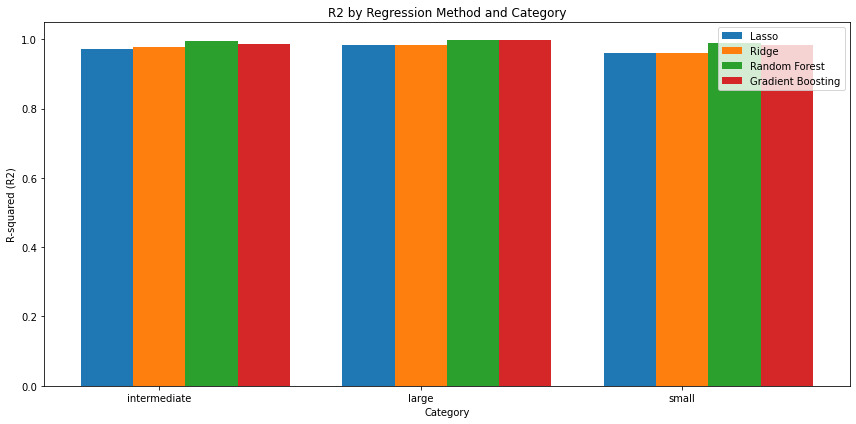

In [15]:
# Results from the four regression methods for "r2"
r2_values = {
    'Lasso': [best_models_lasso[cat]['r2'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['r2'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['r2'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['r2'] for cat in categories]
}

plot_error_chart(r2_values, "R2 by Regression Method and Category", "Category", "R-squared (R2)")

#### Conclusion
There isn't a significant difference in r2 score between models and categories.

<a id="hypothesis"></a>
## Hypothesis Testing

### Hypothesis I
Our hypothesis states that warning signs can be identified in deposit data that indicate potential changes in non-maturity deposit levels. (Null hypothesis: deposit fluctuations are random and cannot be predicted based on historical data.)

To test the hypothesis, we can compare the evaluation metric (e.g., RMSE) of models with a baseline model (e.g., a model that predicts deposit fluctuations are random). If the evaluation metric of such as the Lasso regression or other model is significantly lower than the baseline model, it provides evidence to reject the null hypothesis.

A suitable baseline model might be a model that simply predicts the average deposit change or no change in deposits over time. This model assumes that deposit fluctuations are random and cannot be predicted, providing a benchmark for comparison with the Lasso regression or other models.

In [16]:
def calculate_baseline_rmse(lagged_df, category):
    """
    Calculate the baseline RMSE for a given category.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.
    - category (str): Category for which to calculate the baseline RMSE.

    Returns:
    - float: Baseline RMSE for the given category.
    """
    category_df = lagged_df[lagged_df['category'] == category]
    # Calculate the baseline prediction
    baseline_prediction = category_df['total_deposits'].mean()
    baseline_rmse = mean_squared_error(category_df['total_deposits'], [baseline_prediction] * len(category_df), squared=False)
    return baseline_rmse

for cat in lagged_df['category'].unique():
    baseline_rmse = calculate_baseline_rmse(lagged_df, cat)
    print(f"Category: {cat}")
    print(f"Baseline RMSE: {baseline_rmse}")
    print()

Category: intermediate
Baseline RMSE: 0.12678777543571101

Category: large
Baseline RMSE: 0.26650556302297806

Category: small
Baseline RMSE: 0.2634539738304638



C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


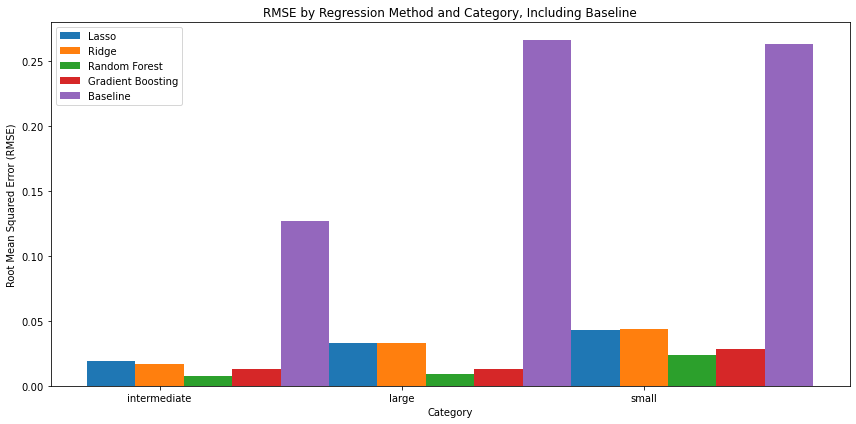

In [17]:
mse_values = {
    'Lasso': [best_models_lasso[cat]['rmse'] for cat in categories],
    'Ridge': [best_models_ridge[cat]['rmse'] for cat in categories],
    'Random Forest': [best_models_random_forest[cat]['rmse'] for cat in categories],
    'Gradient Boosting': [best_models_gradient_boosting[cat]['rmse'] for cat in categories],
    'Baseline': [calculate_baseline_rmse(lagged_df, cat) for cat in categories]
}

plot_error_chart(mse_values, "RMSE by Regression Method and Category, Including Baseline", "Category", "Root Mean Squared Error (RMSE)")

#### Conclusion
The evaluation metrics of models are significantly lower than the baseline model, it provides evidence to reject the null hypothesis which means deposit fluctuations are not random and can be predicted based on historical data

#### Hypothesis II
Our hypothesis states that there are significant differences in deposit trends among different categories of banks by asset size.
(Null hypothesis: there are no significant differences between these categories).

To test this hypothesis, we can use ANOVA (Analysis of Variance) to determine if there are significant differences in deposit trends among different categories of banks by asset size.

Pairwise Comparison: ('intermediate', 'large'), p-value: 8.115705884721927e-13, Decision: Reject null hypothesis
Pairwise Comparison: ('intermediate', 'small'), p-value: 1.437356198949479e-09, Decision: Reject null hypothesis
Pairwise Comparison: ('large', 'small'), p-value: 0.27870535087787507, Decision: Fail to reject null hypothesis


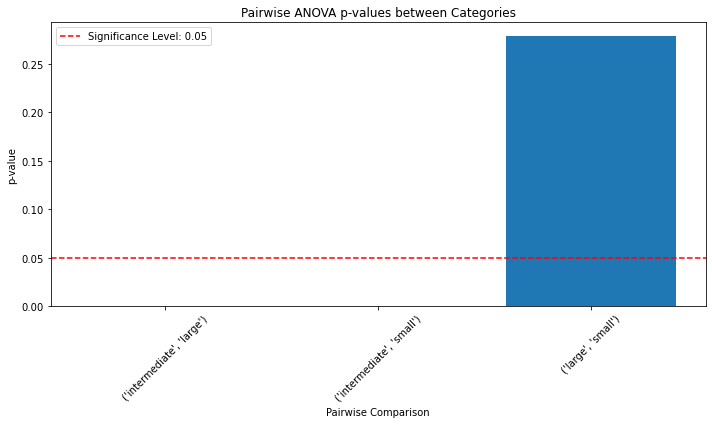

In [18]:
def pairwise_anova(lagged_df):
    """
    Perform pairwise ANOVA comparisons between categories.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.

    Returns:
    - DataFrame: DataFrame containing pairwise ANOVA p-values.
    """
    categories = lagged_df['category'].unique()
    pairwise_comparisons = list(combinations(categories, 2))

    p_values = []
    for cat1, cat2 in pairwise_comparisons:
        data_cat1 = lagged_df[lagged_df['category'] == cat1]['total_deposits']
        data_cat2 = lagged_df[lagged_df['category'] == cat2]['total_deposits']
        result = f_oneway(data_cat1, data_cat2)
        p_values.append(result.pvalue)

    pairwise_anova_results = pd.DataFrame({'Pairwise Comparison': pairwise_comparisons, 'p-value': p_values})
    
    for i, row in pairwise_anova_results.iterrows():
        if row['p-value'] < 0.05:
            decision = 'Reject null hypothesis'
        else:
            decision = 'Fail to reject null hypothesis'
        print(f"Pairwise Comparison: {row['Pairwise Comparison']}, p-value: {row['p-value']}, Decision: {decision}")

    return pairwise_anova_results

pairwise_anova_results = pairwise_anova(lagged_df)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(pairwise_anova_results)), pairwise_anova_results['p-value'], tick_label=pairwise_anova_results['Pairwise Comparison'])
ax.axhline(y=0.05, color='r', linestyle='--', label='Significance Level: 0.05')
ax.set_xlabel('Pairwise Comparison')
ax.set_ylabel('p-value')
ax.set_title('Pairwise ANOVA p-values between Categories')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conclusion
For the large vs intermediate and intermediate vs small: p-value is less than the significance level (e.g., 0.05), therefore we reject the null hypothesis, and conclude that there are significant differences in deposit trends among different categories of banks by asset size. However, it's opposite for large vs small categories.

This pattern could indicate that there are distinct differences in deposit trends between adjacent categories (e.g., "large" vs "intermediate" and "intermediate" vs "small"), but the differences between non-adjacent categories (e.g., "large" vs "small") are not as pronounced. This could be due to specific characteristics or behaviors that are more similar between the "large" and "small" categories compared to the other pairwise comparisons. Large vs small banks having similar values is unintuitive and may warrant further analysis.

<a id="ablation"></a>
## Ablation analysis

Ablation analysis refers to a technique used to understand the importance of different features (predictors) in the predictive model. It involves systematically removing one feature at a time from the model and observing how it affects the model's performance. By doing so, we can identify which features have the most significant impact on the model's predictions.

In [ ]:
def stylized_ablation_analysis(lagged_df, selected_features, model_functions):
    """
    Perform ablation analysis by iteratively removing each feature from selected_features and evaluating the specified model functions.

    Args:
    - lagged_df (DataFrame): DataFrame containing the lagged data.
    - selected_features (list): List of selected features.
    - model_functions (dict): Dictionary containing model functions (e.g., {'Lasso': run_lasso_ols, 'Ridge': run_ridge_ols}).

    Returns:
    - DataFrame: DataFrame containing the top 3 models with the best performance for each feature removal.
    """
    results = []

    for feature in selected_features:
        features_without_current = [f for f in selected_features if f != feature]
        model_results = {}

        for model_name, (model, param_grid, cv) in model_functions.items():
            best_models = run_sklearn_model(lagged_df, features_without_current, model, param_grid, cv)
            top_models = sorted(best_models.items(), key=lambda x: x[1]['rmse'])[:3]
            model_results[model_name] = top_models

        results.append({'feature_excluded': feature, 'results': model_results})

    rows = []
    for result in results:
        feature = result['feature_excluded']
        features_in_use = ', '.join([f for f in selected_features if f != feature])
        for model_name, top_models in result['results'].items():
            for rank, (category, metrics) in enumerate(top_models, start=1):
                rows.append({'feature_excluded': feature, 'features_in_use': features_in_use, 'model': model_name, 'rank': rank, 'category': category, 'rmse': metrics['rmse']})

    results_df = pd.DataFrame(rows)
    
    idx = results_df.groupby('category')['rmse'].idxmin()
    styled_df = results_df.style.apply(lambda x: ['background-color: yellow' if x.name in idx.values else '' for i in x], axis=1)

    return styled_df

model_functions = {
    'Lasso': (Lasso(max_iter=10000), grid_lasso, 5),
    'Ridge': (Ridge(), grid_ridge, 3),
    'Random Forest': (RandomForestRegressor(random_state=random_state), grid_forest, 3),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=random_state), grid_boost, 3)
}

ablation_results = stylized_ablation_analysis(lagged_df, selected_features, model_functions)
ablation_results

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program files\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

#### Conclusion

Based on analysis above, random forest is still the best model. Its best combination of features for each category as follows:

- Large: of cpi, fed_fund_rate, housing_starts, umich_consumer_sentiment_index (exclude personal_savings_rate)
- Intermediate: cpi, housing_starts, personal_savings_rate, umich_consumer_sentiment_index (exclude fed_fund_rate)
- Small: cpi, fed_fund_rate, housing_starts, personal_savings_rate (exclude umich_consumer_sentiment_index)

However, 